<br>Code up an (optionally denoising) AutoEncoder with Keras
<br>Keep it simple to start. Don't use more than 3 layers

<br> 1. Try different initializers 
<br> 2. Use a small positive bias with relu
<br> 3. Add Weight decay
<br> 4. Try different optimizers and loss functions

Import Packages

In [1]:
import numpy as np
import seaborn as sns
import scipy.io as sio
import random
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
% matplotlib inline

# AlexNet Dependencies
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.python.keras.models import Model, model_from_json
from tensorflow.python.keras import backend as K

from sklearn.metrics import confusion_matrix

C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\1130135\AppData\Loc

Define Helper Functions

In [2]:
# Converts integer labels into one-hot vectors
def to_one_hot(labels, n_classes, p_max = 1.0):
    # Calculate the minimum probability of class based on max probability
    p_min = 0.0 if p_max == 1.0 else (1.0 - p_max)/(n_classes - 1)

    # allocate memory for one hot labels
    labels = labels.astype(np.int32)
    n_labels = labels.shape[0]
    oh_labels = np.full((n_labels, n_classes), p_min)
    # minus 1 because Matlab uses 1 based indexing
    oh_labels[np.arange(n_labels), labels-1] = p_max
    return oh_labels

def to_int_label(labels):
    int_labels = np.zeros((len(labels),))
    for i in range(len(labels)):
        int_labels[i] = np.argmax(labels[i])
    return int_labels

# Convert batch, pixels --> batch, rows, cols, 1_channel
def to_img(x):
    return np.reshape(x, [-1, im_rows, im_cols, 1])


# Restore values from memory (TF also supports restoring from a file)
def set_best_vars(sess, best_vars_vals, trainable_vars):
    restore_ops = [avar.assign(best_val) for best_val, avar in zip(best_vars_vals, trainable_vars)]
    sess.run(restore_ops)

Define Constants

In [3]:
## To speed up validation
MAX_VALIDATION_SAMPLES = int(2000) # at most 10,000 in this dataset

Import Data

In [4]:
TRAINING_FILE = '../training.mat'
VALIDATION_FILE = '../validation.mat'
TESTING_FILE = '../testing.mat'

In [5]:
## Data
print('Loading Training Data')
training_data = sio.loadmat(TRAINING_FILE, squeeze_me=True)
training_ims = training_data['data'].T  # .T --> transpose
training_labels = training_data['labels']

# Validation Data
print('Loading Validation Data')
validation_data = sio.loadmat(VALIDATION_FILE, squeeze_me=True)
validation_ims = validation_data['data'].T
validation_labels = validation_data['labels']
# Limit our Validation data since we don't really need 10k of them
validation_ims = validation_ims[:MAX_VALIDATION_SAMPLES]
validation_labels = validation_labels[:MAX_VALIDATION_SAMPLES]


# Testing data
print('Loading Testing Data')
testing_data = sio.loadmat(TESTING_FILE, squeeze_me=True)
testing_ims = testing_data['data'].T
testing_labels = testing_data['labels']

Loading Training Data
Loading Validation Data
Loading Testing Data


Data Attributes

In [6]:
## Data attributes (look them up, but are effectively constant)
# These could be hard coded, but extracting them from the data anyway
im_rows = im_cols = int(np.sqrt(testing_ims.shape[1]))
print('Number of Rows/Cols:', im_rows)
num_classes = int(np.amax(testing_labels))
print('Number of Classes:', num_classes)

Number of Rows/Cols: 28
Number of Classes: 10


Data Pre-processing

In [7]:
## Data preprocessing
print('Reformating labels to one-hot')
training_labels   = to_one_hot(training_labels, num_classes)
validation_labels = to_one_hot(validation_labels, num_classes)
testing_labels    = to_one_hot(testing_labels, num_classes)

Reformating labels to one-hot


In [9]:
x_train = training_ims.astype('float32') / 1.
x_val   = validation_ims.astype('float32') / 1.
x_test  = testing_ims.astype('float32') / 1.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val   = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(50000, 784)
(2000, 784)
(10000, 784)


Training Attributes

In [10]:
## Training attributes
INPUT_SHAPE = [im_rows,im_cols,1]
BATCH_SIZE = int(100)
MAX_ITER = int(500000)  # 5 million should be enough
WEIGHT_DECAY = 5e-4  # This is what AlexNet used

# Checkpoint, because someday your computer will power down unexpectedly
CHKPNT_FNAME = './chkpnts/chkpnt'
CHKPNT_LATEST_FNAME = 'chkpnt_latest'
CHKPNT_LATEST_FULL = './chkpnts/' + CHKPNT_LATEST_FNAME

# Number of channels
NUM_CONV_CHANS = np.array([1, 24, 64, 96])  # AlexNet used 3, 48, 128, 192 (colored images)

# Filter sizes
C_SIZES = [6, 3, 2]  # AlexNet technically uses 11x11, 5x5, 3x3... on 224x224 images. MNIST is 28x28
C_SIZES = np.array(C_SIZES)  # Lets us treat the array like a matlab array

# Strides
C_STRIDES = [2, 1, 1]  # AlexNet used 4x4 strides to start
C_STRIDES = np.array(C_STRIDES)

# Pooling
C_POOLS = [2, 1, 1]
C_POOLS = np.array(C_POOLS)

Determine Network Parameters

In [11]:
# Feature map sizes CALCULATE THEM
'''
Formula for the sizes (valid convolution):
Let i be image dimension
Let n be filter size
Let k be stride size
Let p be pooling size
Let o be output image dimension

(1 + (i - n)/k)/p = o
Requires: (i - n)%k == 0
Requires: (1 + (i - n)/k)%p == 0

In words, the number of strides is equal to 1 + (i-n)/k. You always have 1 sample (iff i>=n).
The number of unconvolved slots is i-n, which must be evenly divisible by the stride length, k.
Pooling performs integer division of this result, which should also have 0 remainder.

solved for each variable:
o = (1 + (i - n)/k)/p
p = (1 + (i - n)/k)/o
k = (i - n)/(o * p - 1)
n = i - (o * p - 1)*k
i = (o * p - 1)*k + n

example: suppose we want to use 10x10 filters with stride 3 on a 71x71 img. Is it valid?
(71 - 10)%3 != 0
Can we modify this slightly?
(71 - 11)%3 == 0
o = 1 + (71 - 11)/3 = 21 without pooling.


hint think of 'o' as the next value in C_FEATURES
     think of 'i' as the previous value in C_FEATURES
'''


C_FEATURES = [im_rows, 0, 0, 0]  #Zeroth index is input feature_width
print('C_FEATURES',C_FEATURES)

C_FEATURES [28, 0, 0, 0]


In [12]:
'''

FILL IN THE NUMBER OF ROWS IN EACH FEATURE MAP (C_FEATURES).

ASSUME WE ARE USING 3 CONVOLUTIONAL LAYERS DEFINED BY
C_SIZES, C_STRIDES, C_POOLS

HINT: EACH SUBSEQUENT FEATURE MAP DEPENDS ON THE PREVIOUS FEATURE MAP

'''
C_FEATURES = np.array(C_FEATURES, dtype=np.int32)  # Convert to numpy array
print('C_FEATURES',C_FEATURES)

C_FEATURES [28  0  0  0]


In [13]:
'''

N_FEATURES = TOTAL NUMBER OF VALUES OUTPUT AT THE LAST CONVOLUTIONAL LAYER
THIS DEPENDS ON THE NUMBER OF CHANNELS AS WELL AS THE FEATURE MAP SIZE

FILL IN HOW MANY NUMBER ARE IN THE LAST LAYER

'''
# N_FEATURES = int(0)
N_FEATURES = num_classes

# Fully connected layer, zeroth index is size of output of CNN
FC_SIZES = [N_FEATURES, 384, num_classes]  # AlexNet used 2048x2048

print('N_FEATURES',N_FEATURES)
print('FC_SIZES',FC_SIZES)

N_FEATURES 10
FC_SIZES [10, 384, 10]


In [14]:
# Filters defined, by default, using row, column, input channels, output channels
filter_dims = [[] for _ in range(len(C_SIZES))]

# Pooling defined, by default, using batch, row, column, channel
poolings = [[] for _ in range(len(C_SIZES))]

# Strides defined, by default, using batch, row, column, channel
filter_strides = [[] for _ in range(len(C_SIZES))]

for ii in range(len(C_SIZES)):
    filter_dims[ii] = [C_SIZES[ii], C_SIZES[ii], NUM_CONV_CHANS[ii], NUM_CONV_CHANS[ii+1]]
    poolings[ii] = C_POOLS[ii]
    filter_strides[ii] = [C_STRIDES[ii],C_STRIDES[ii]]
    
print('filter_dims:', filter_dims)
print('poolings:', poolings)
print('filter_strides:', filter_strides)

filter_dims: [[6, 6, 1, 24], [3, 3, 24, 64], [2, 2, 64, 96]]
poolings: [2, 1, 1]
filter_strides: [[2, 2], [1, 1], [1, 1]]


# Simplified AutoEncoder

In [15]:
# Input Dimension
input_dim = im_rows*im_cols

# Dimension of encoded representation
encoding_dim = 32

In [16]:
def AutoEncoder(input_dim, encoding_dim):
    
    # Input Image
    X_input = Input(shape=(input_dim,),name = "input")
    
    # Encoded representation of input
    X = Dense(encoding_dim, activation='relu', name = "encoder")(X_input)
    
    # Decoded / lossy reconstruction of input
    X = Dense(input_dim, activation='sigmoid', name = "decoder")(X)
    
    # Model that maps input to its reconstruction
    model = Model(inputs = X_input, outputs = X, name='AutoEncoder')

    return model

In [17]:
autoencoder = AutoEncoder(input_dim, encoding_dim)

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [19]:
autoencoder.compile(optimizer = 'adam' , loss = 'binary_crossentropy')

In [20]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, x_val))

Train on 50000 samples, validate on 2000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.1699 - val_loss: 0.1200
Epoch 2/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.1092 - val_loss: 0.1015
Epoch 3/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.0983 - val_loss: 0.0965
Epoch 4/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.0956 - val_loss: 0.0953
Epoch 5/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.0948 - val_loss: 0.0947
Epoch 6/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.0944 - val_loss: 0.0946
Epoch 7/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.0942 - val_loss: 0.0945
Epoch 8/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.0940 - val_loss: 0.0942
Epoch 9/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.0939 - val_loss: 0.0943
Epoch 

In [21]:
layer_name = 'encoder'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
encoded_imgs = encoder.predict(x_test)

layer_name = 'decoder'
decoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
decoded_imgs = decoder.predict(x_test)

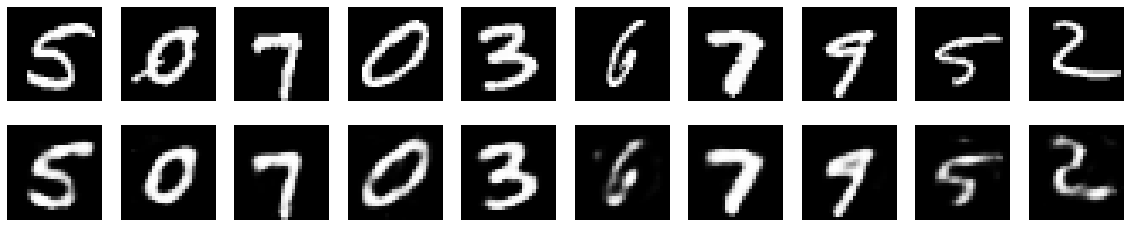

In [22]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    index = random.randint(0,len(x_test))
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising AutoEncoder

In [24]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

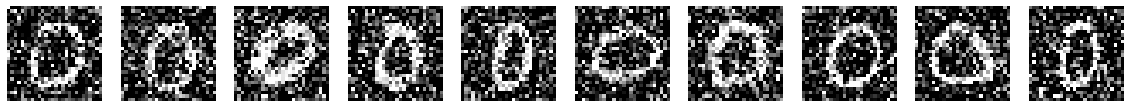

In [26]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
def AutoEncoder(input_shape=(28,28,1)):
    
    # Input Image
    X_input = Input(shape=input_shape,name = "input")
    
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv0")(X_input)
    X = MaxPooling2D((2,2), padding='same', name = 'max0')(X)
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv1")(X)
    encoded = MaxPooling2D((2,2), padding='same', name = 'encoded')(X)
    
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv2")(encoded)
    X = UpSampling2D((2,2), name = 'upsample0')(X)
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv3")(X)
    X = UpSampling2D((2,2), name = 'upsample1')(X)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(X)
    
    # Model that maps input to its reconstruction
    model = Model(inputs = X_input, outputs = decoded, name='AutoEncoder')

    return model

In [28]:
autoencoder = AutoEncoder()

In [29]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max0 (MaxPooling2D)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        9248      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 32)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 32)          9248      
_________________________________________________________________
upsample0 (UpSampling2D)     (None, 14, 14, 32)        0         
__________

In [30]:
autoencoder.compile(optimizer = 'adam' , loss = 'binary_crossentropy')

In [31]:
from tensorflow.python.keras.callbacks import TensorBoard

history = autoencoder.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 121s 2ms/step - loss: 4.0674 - val_loss: 3.3999
Epoch 2/50
50000/50000 [==============================] - 113s 2ms/step - loss: 3.3103 - val_loss: 3.2027
Epoch 3/50
50000/50000 [==============================] - 119s 2ms/step - loss: 3.1990 - val_loss: 3.1305
Epoch 4/50
50000/50000 [==============================] - 119s 2ms/step - loss: 3.1419 - val_loss: 3.1086
Epoch 5/50
50000/50000 [==============================] - 118s 2ms/step - loss: 3.1100 - val_loss: 3.0826
Epoch 6/50
50000/50000 [==============================] - 122s 2ms/step - loss: 3.0886 - val_loss: 3.0750
Epoch 7/50
50000/50000 [==============================] - 122s 2ms/step - loss: 3.0719 - val_loss: 3.0455
Epoch 8/50
50000/50000 [==============================] - 122s 2ms/step - loss: 3.0606 - val_loss: 3.0355
Epoch 9/50
50000/50000 [==============================] - 121s 2ms/step - loss: 3.0524 - val_loss: 3.0

KeyboardInterrupt: 

In [32]:
layer_name = 'decoded'
decoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
decoded_imgs = decoder.predict(x_test_noisy)

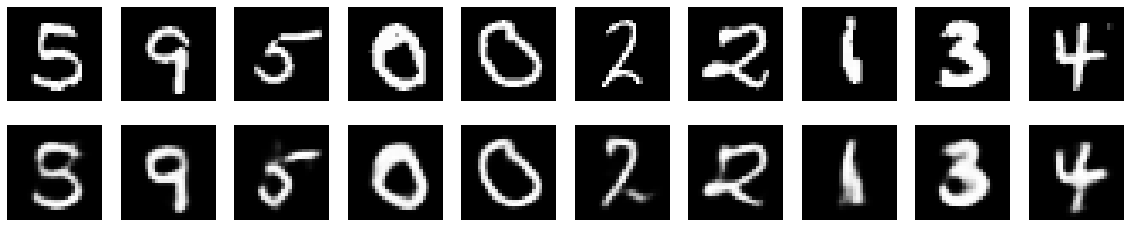

In [33]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    index = random.randint(0,len(x_test))
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

LLE: 0.14 sec
LTSA: 0.23 sec
Hessian LLE: 0.31 sec
Modified LLE: 0.28 sec
Isomap: 0.44 sec
MDS: 2.2 sec
SE: 0.11 sec


C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


t-SNE: 3.9 sec


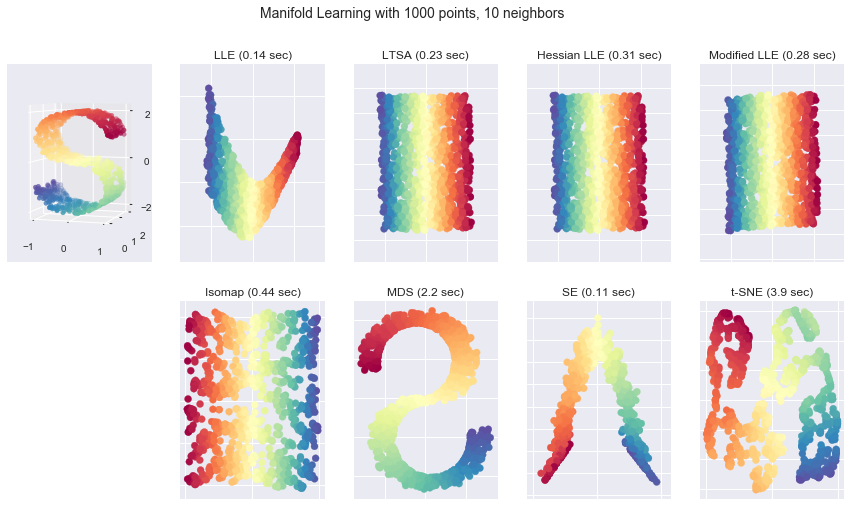

In [34]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()



N_FEATURES = TOTAL NUMBER OF VALUES OUTPUT AT THE LAST CONVOLUTIONAL LAYER
THIS DEPENDS ON THE NUMBER OF CHANNELS AS WELL AS THE FEATURE MAP SIZE

FILL IN HOW MANY NUMBER ARE IN THE LAST LAYER


Computing random projection
Computing PCA projection
Computing Linear Discriminant Analysis projection
Computing Isomap projection
Done.
Computing LLE embedding
Done. Reconstruction error: 1.63544e-06
Computing modified LLE embedding
Done. Reconstruction error: 0.358751
Computing Hessian LLE embedding
Done. Reconstruction error: 0.212802
Computing LTSA embedding
Done. Reconstruction error: 0.212804
Computing MDS embedding
Done. Stress: 138124998.802953
Computing Totally Random Trees embedding
Computing Spectral embedding


C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


Computing t-SNE embedding


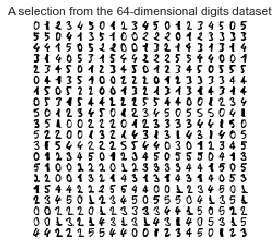

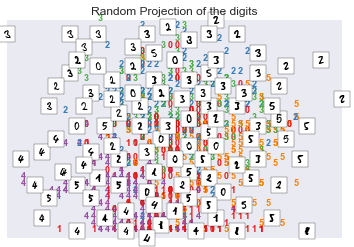

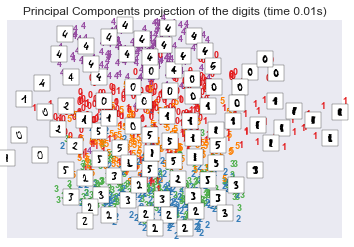

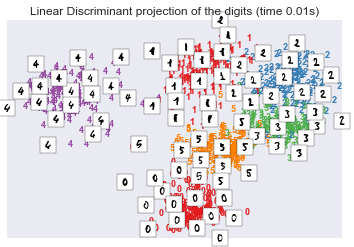

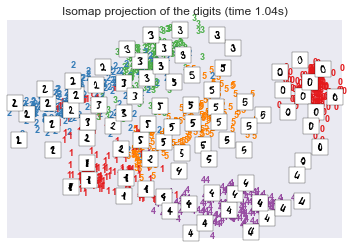

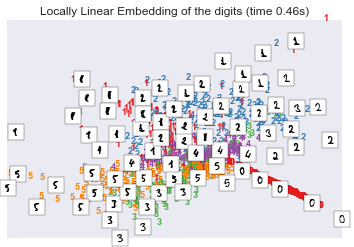

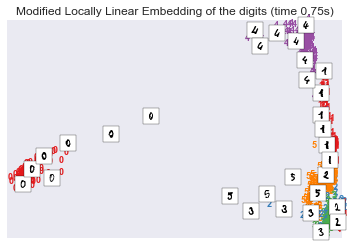

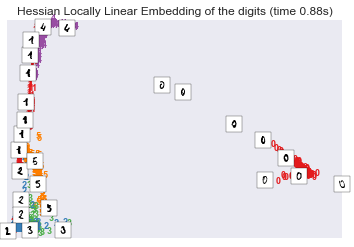

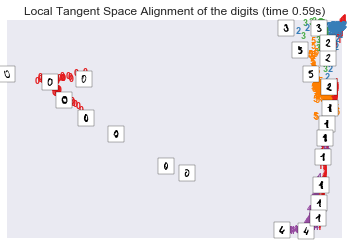

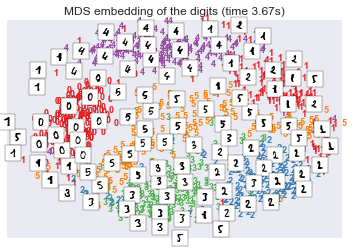

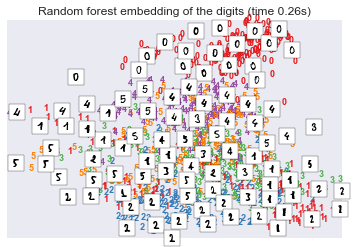

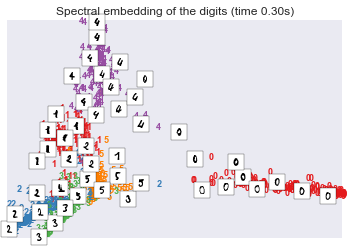

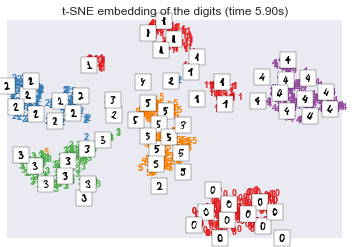

In [37]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
print(__doc__)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30


# ----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


# ----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')


# ----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")


# ----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle,
               "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


# ----------------------------------------------------------------------
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa,
               "Local Tangent Space Alignment of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

# ----------------------------------------------------------------------
# NCA projection of the digits dataset
# print("Computing NCA projection")
# nca = neighbors.NeighborhoodComponentsAnalysis(init='random',
#                                                n_components=2, random_state=0)
# t0 = time()
# X_nca = nca.fit_transform(X, y)

# plot_embedding(X_nca,
#                "NCA embedding of the digits (time %.2fs)" %
#                (time() - t0))

plt.show()